# Multiclass Softmax Classification - MXNet (From Scratch)

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()
print('No of GPUs available on your system:', mx.context.num_gpus())
print('Chosen device as your ctx:', ctx)

No of GPUs available on your system: 1
Chosen device as your ctx: gpu(0)


## Getting our dataset

In [ ]:
def transform(data, label):
    return data.astype('float32')/255.0, label.astype('float32')
    # diving by 255 so that min and max of our data is 0 and 1 respectively.

train_mnist = gluon.data.vision.MNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.MNIST(train = False, transform = transform)

In [3]:
image, label = train_mnist[0]
print(image.shape, label.shape)

(28, 28, 1) ()


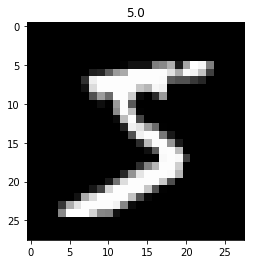

In [4]:
plt.imshow(image.reshape((28, 28)).asnumpy(), cmap = 'gray')
plt.title(label)
plt.show()


## Creating data loader for training and testing

In [5]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

print('No of batches for batch size {} is {}'.format(batch_size, len(train_data)))

No of batches for batch size 64 is 938


## Softmax funtion

$\text{softmax}\left(x\right) = \large\frac{x^{e}}{\sum{x^{e}}}$

In [1]:
def softmax(linear):
    exp = nd.exp(linear - nd.max(linear, axis = 1).reshape((-1, 1)))
    norms = nd.sum(exp, axis = 1).reshape((-1, 1))
    return exp / norms

## Building the model

In [ ]:
weight = nd.random.normal(shape = (784, 10), ctx = ctx)
bias = nd.random.normal(shape = 10, ctx = ctx)
params = [weight, bias]

for param in params:
    param.attach_grad()

def softmaxclassification(inputs):
    return softmax(nd.dot(inputs, weight) + bias)

## Defining our objective function

### Categorical cross entropy $\left(x\right) = \sum{y_{i} * \log{\hat{y}_{i}}}$

In [ ]:
def categoricalcrossentropy(predictions, labels):
    return -nd.sum(labels * nd.log(predictions))

## Defining our parameters optimizer(Gradient Decent)

In [ ]:
def sgd(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

## Defining our accuracy function

In [ ]:
def accuracy(predictions, labels):
    return nd.mean(predictions.argmax(1) == labels.argmax(1))

## Training the model

## Understanding one hot representation

- If the label is 0 then it's one hot vector is [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

- If the label is 1 then it's one hot vector is [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

- If the label is 2 then it's one hot vector is [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [14]:
epochs = 20
num_batches = len(train_data)
learning_rate = .001 # you can change it to 0.01 for faster training
losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    for features, labels in train_data:
        features = features.as_in_context(ctx).reshape((-1, 784))
        labels = labels.as_in_context(ctx).one_hot(10)
        
        with autograd.record():
            output = softmaxclassification(features)
            loss = categoricalcrossentropy(output, labels)
        loss.backward()
        sgd(params, learning_rate)
        
        cumulative_loss += loss
        cumulative_acc += accuracy(output, labels)
        
    print(f'Epoch: {epoch} Loss: {cumulative_loss.asscalar()/num_batches} Accuracy: {cumulative_acc.asscalar()/num_batches}')
    losses.append(cumulative_loss.asscalar()/num_batches)
    accs.append(cumulative_acc.asscalar()/num_batches)

Epoch: 0 Loss: 166.87108542110875 Accuracy: 0.6077258795309168
Epoch: 1 Loss: 69.74727645255864 Accuracy: 0.7869469616204691
Epoch: 2 Loss: 55.523624900053306 Accuracy: 0.8232276119402985
Epoch: 3 Loss: 48.41943463486141 Accuracy: 0.8405350479744137
Epoch: 4 Loss: 43.90106942963752 Accuracy: 0.8513459488272921
Epoch: 5 Loss: 40.73669459621535 Accuracy: 0.859358342217484
Epoch: 6 Loss: 38.32090385127932 Accuracy: 0.8653884594882729
Epoch: 7 Loss: 36.39406066764392 Accuracy: 0.8696695095948828
Epoch: 8 Loss: 34.838059285047976 Accuracy: 0.8740338486140725
Epoch: 9 Loss: 33.51272654584222 Accuracy: 0.8773820628997868
Epoch: 10 Loss: 32.35088994203092 Accuracy: 0.8799806769722814
Epoch: 11 Loss: 31.425745852212152 Accuracy: 0.8827292110874201
Epoch: 12 Loss: 30.512122701226012 Accuracy: 0.8856609808102346
Epoch: 13 Loss: 29.773439582222814 Accuracy: 0.8876265991471215
Epoch: 14 Loss: 29.096825443097014 Accuracy: 0.8897754530916845
Epoch: 15 Loss: 28.446257829157783 Accuracy: 0.890791577825

## Lets see test accuracy

In [16]:
acc = 0.0
test_batches = len(test_data)
for features, labels in test_data:
    features = features.as_in_context(ctx).reshape((-1, 784))
    labels = labels.as_in_context(ctx).one_hot(10)
    predictions = softmaxclassification(features)
    acc += accuracy(predictions, labels)
    
print(f'Test Accuracy: {acc.asscalar()/test_batches}')

Test Accuracy: 0.8939092356687898


In [ ]:
def plot(losses = losses, accs = accs, model = softmaxclassification):
    samples = 16
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure(figsize = (15, 15))

    for i, example in enumerate(test_mnist, 1):
        features = example[0].as_in_context(ctx).reshape((1, 784))
        labels = example[1]
        predictions = softmaxclassification(features).argmax(1).asscalar()
        plt.subplot(4, 4, i)
        plt.imshow(features.reshape((28, 28)).asnumpy(), cmap = 'gray')
        plt.axis('off')
        plt.title(f'Predicted: {predictions}, Target: {labels}')
        if i == samples:
            break
    plt.show()

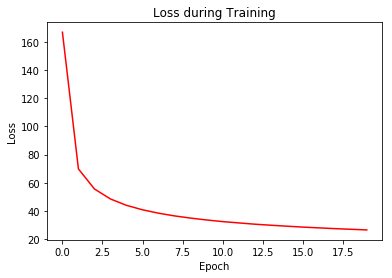

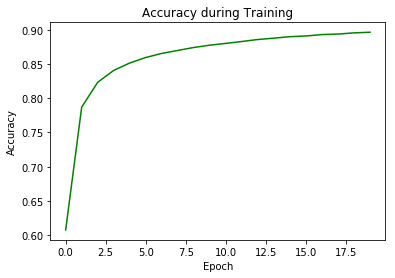

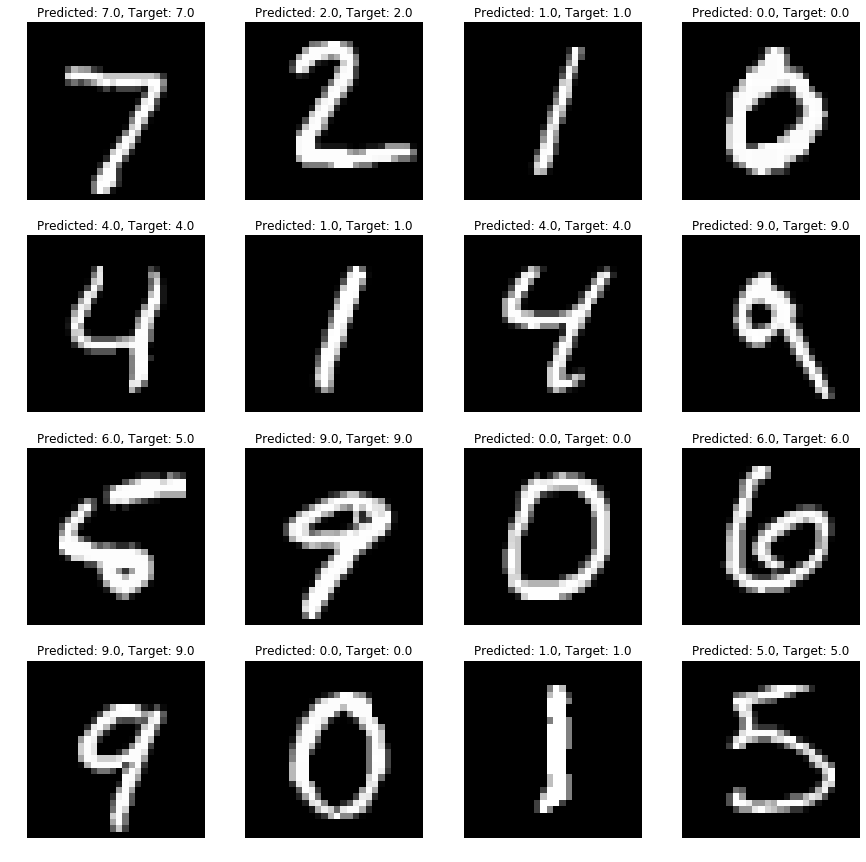

In [43]:
plot()